In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from commandtemplate.conda import run_template_bash
import itertools
from pathlib import Path
import numpy as np
from scipy.stats import fisher_exact
from statannotations.Annotator import Annotator

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"
conda_env = "DI"

# Element counts

In [4]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal_intergenic", "distal_intragenic", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]
clsname = " ".join(gs)

## Before filtering

In [5]:
files = [f"{PROJECT_DIR_d}bed_pd/{s}_{g}.bed" for g in gs]
filestr = " ".join(["{i" + str(idx) + "}" for idx in range(len(files))])
run_template_bash(
	"biodatatools annotate_bed_classes -i " + filestr + " -clsname {clsname} -column 3 -o - | cut -f 1-4 | biodatatools summarize_bed_annotation_counts -i - -name {name} -o {o} -func 'lambda d: d[-1]'",
	conda_env=conda_env,
	**{f"i{idx}": file for idx, file in enumerate(files)},
	clsname=clsname,
	name="No.elements",
	o=f"{PROJECT_DIR_d}bed_plot/{s}_counts_raw.bed"
)

In [6]:
def plot_counts(df_count, outputfile, xlims, figy):
	fig, ax = plt.subplots(1, 1, figsize=(2.6,figy))
	order = [g for g in gs if "distal" in g] + [g for g in gs if "proximal" in g]
	ticklabels = [g.split("_")[0].capitalize() + " (" + g.split("_")[-1] + ")" if "distal" in g else g.split("_")[0].capitalize() for g in order]
			
	g = sns.barplot(data=df_count, y="Group", x="No.elements",
					order=order, orient="h",
					hue="Group",
					palette=["#fb8072", "#fdb462", "#80b1d3"]*2, 
					ax=ax)

	n = 0
	for i in g.containers:
		g.bar_label(i, padding=5, fontsize=sfontsize)
		for bar in i:
			if n >= 3:
				bar.set_alpha(0.5)
			n += 1
	
	g.set_xlabel("No. elements", fontsize=bfontsize, labelpad=5)
	g.set_ylabel("")
	g.set_xticks([])
	g.tick_params(axis="y", labelsize=sfontsize, pad=5)
	g.set_yticks(g.get_yticks())
	g.set_yticklabels(ticklabels)
	g.spines.right.set_visible(False)
	g.spines.top.set_visible(False)
	trans = g.get_yaxis_transform()
	x1 = -0.92
	x2 = -0.85
	g.annotate("Distal", xy=(x1,0.75), xycoords=trans, ha="center", va="top", fontsize=bfontsize, rotation=90)
	g.annotate("Proximal", xy=(x1,3.55), xycoords=trans, ha="center", va="top", fontsize=bfontsize, rotation=90)
	g.plot([x2,x2],[-0.3,3.4], color="k", transform=trans, clip_on=False, linewidth=1)
	g.plot([x2,x2],[3.7,5.5], color="k", transform=trans, clip_on=False, linewidth=1)
	g.set_xlim(xlims)

	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

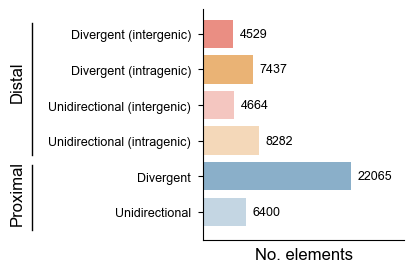

In [7]:
df_raw = pd.read_table(f"{PROJECT_DIR_d}bed_plot/{s}_counts_raw.bed")
outputfile = f"{PROJECT_DIR_o}figures/Fig1b.pdf"
plot_counts(df_raw, outputfile, [0,30000], 3)

## After filtering

In [8]:
files = [f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed" for g in gs]
filestr = " ".join(["{i" + str(idx) + "}" for idx in range(len(files))])
run_template_bash(
	"biodatatools annotate_bed_classes -i " + filestr + " -clsname {clsname} -column 3 -o - | cut -f 1-4 | biodatatools summarize_bed_annotation_counts -i - -name {name} -o {o} -func 'lambda d: d[-1]'",
	conda_env=conda_env,
	**{f"i{idx}": file for idx, file in enumerate(files)},
	clsname=clsname,
	name="No.elements",
	o=f"{PROJECT_DIR_d}bed_plot/{s}_counts_filtered.bed"
)

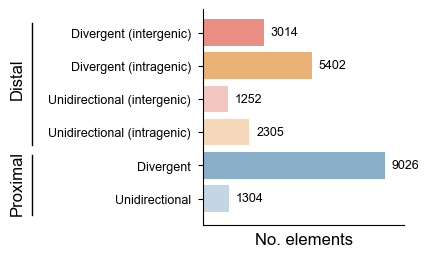

In [9]:
df_filtered = pd.read_table(f"{PROJECT_DIR_d}bed_plot/{s}_counts_filtered.bed")
outputfile = f"{PROJECT_DIR_o}figures/ExtDataFig1b.pdf"
plot_counts(df_filtered, outputfile, [0,10000], 2.8)

In [10]:
# Check if distal elements have a higher fraction of unidirectional elements

for df in [df_raw, df_filtered]:
	n1 = np.sum(df[df["Group"].isin(["unidirectional_distal_intergenic", "unidirectional_distal_intragenic"])]["No.elements"])
	n2 = np.sum(df[df["Group"].isin(["divergent_distal_intergenic", "divergent_distal_intragenic"])]["No.elements"])
	n3 = int(df.loc[df["Group"] == "unidirectional_proximal", "No.elements"].iloc[0])
	n4 = int(df.loc[df["Group"] == "divergent_proximal", "No.elements"].iloc[0])
	OR, pvalue = fisher_exact([[n1,n2],[n3,n4]], alternative="greater")
	k = "Before filtering" if df is df_raw else "After filtering"
	print(f"{k}: OR={OR:f}, p={pvalue:e}")

Before filtering: OR=3.730015, p=0.000000e+00
After filtering: OR=2.925472, p=2.274679e-216


# DI distribution

In [11]:
files = [f"{PROJECT_DIR_d}bed_plot/{s}_{p}_{d}.bed" for d in ds for p in ps]
clsname2 = " ".join([f"{p}_{d}" for d in ds for p in ps])
filestr = " ".join(["{i" + str(idx) + "}" for idx in range(len(files))])
run_template_bash(
	"biodatatools annotate_bed_classes -i " + filestr + " -clsname {clsname} -column 3 -o - | cut -f 1-4 | biodatatools annotate_bed_directionality_index -i - -ipl {ipl} -imn {imn} -o {o}",
	conda_env=conda_env,
	**{f"i{idx}": file for idx, file in enumerate(files)},
	ipl=f"{PROJECT_DIR_d}Alignments/brm_C1a_and_C1b_erm_5pl.bw",
	imn=f"{PROJECT_DIR_d}Alignments/brm_C1a_and_C1b_erm_5mn.bw",
	clsname=clsname2,
	o=f"{PROJECT_DIR_d}bed_plot/{s}_DI.bed"
)

In [12]:
df_DI = pd.read_table(f"{PROJECT_DIR_d}bed_plot/{s}_DI.bed", header=None)
df_DI.columns = ["chrom", "start", "end", "group", "DI"]
df_DI.head(2)

,chrom,start,end,group,DI
0,chr1,1058196,1058697,divergent_distal_intergenic,0.949458
1,chr1,1207961,1208462,divergent_distal_intergenic,0.653846


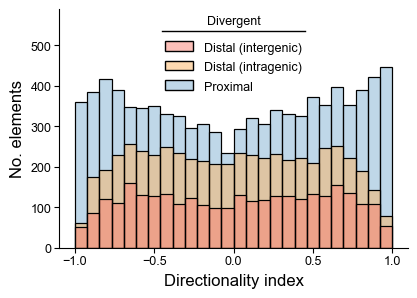

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(4.5,3.1))
g = sns.histplot(data=df_DI[df_DI["group"].str.contains("divergent")], x="DI", hue="group", palette=["#fb8072", "#fdb462", "#80b1d3"], ax=ax)
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 1), frameon=False)
g.legend_.set_title("Divergent", prop={"size":sfontsize})
g.legend_.get_title().set_position((0, 7))
for text in g.legend_.get_texts():
	current_text = text.get_text()
	if "distal" in current_text:
	    text.set_text(f"{current_text.split('_')[1].capitalize()} ({current_text.split('_')[2]})")
	else:
	    text.set_text(f"{current_text.split('_')[1].capitalize()}")
	text.set_fontsize(sfontsize)
line = plt.Line2D([-0.45, 0.45], [535, 535], color="k", lw=1)
g.add_line(line)
g.set_ylabel("No. elements", fontsize=bfontsize)
g.set_xlabel("Directionality index", fontsize=bfontsize)
g.set_xticks([-1,-0.5,0,0.5,1])
g.tick_params(labelsize=sfontsize, pad=2)
g.spines.right.set_visible(False)
g.spines.top.set_visible(False)
g.set_ylim([0,590])
outputfile = f"{PROJECT_DIR_o}figures/Fig1c.pdf"
plt.savefig(outputfile, bbox_inches="tight", transparent=True)